 <font size=6><b>DSC 522 Ghost Hunting: Finding a Botnet in Netflow Traffic<br>
    <font size=4>Qs.2 b and Qs.3 h,i,j done by Steven Moore

In [1]:
# Please note!!!  The group had to expand the RAM available to Jupyter for this code to run. 
# We exapnded the RAM to 4GB and recommend you do the same.  Please see the answer to the below
# stackoverflow page concerning expanding the amount of max_buffer_size. 
# https://stackoverflow.com/questions/57948003/how-to-increase-jupyter-notebook-memory-limit

In [2]:
#I was not able to run the full cleaning/encoding process that Mukila did, so I used an intermediate, one-hot-encoded dataset,
#along with the original dataset from which I collected the Y values.
#Though I used one-hot encoding for these methods, Emma also ran these methods with her label encoded dataset, 
#and the differences for the bagging and KMeans accuracy were within .5%. (Differences in downsampling and different random states
#likely contributed to the difference for DBSCAN.) 

import pandas as pd

from sklearn.model_selection import train_test_split
df = pd.read_csv(r'capture20110815-3.pcap.netflow_v2.txt', delim_whitespace=True)
for index, row in df.iterrows():
    if row.Tos in ['Background', 'LEGITIMATE']:
        df.at[index, 'Label'] = 0
    else:
        df.at[index, 'Label'] = 1


C:\Users\jft2456\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.Label.unique()

array([0., 1.])

In [4]:
X = pd.read_csv(r'final X.csv')
df.rename(columns = {list(df)[1]:'Flow_Start',list(df)[2]:'Duration',list(df)[3]:'Protocol',list(df)[10]:'Source_IP',list(df)[11]:'Source_Port',
                    list(df)[12]:'Destination_IP',list(df)[13]:'Destination_Port',list(df)[4]:'Flags',list(df)[5]:'Type_of_Service',
                    list(df)[6]:'Packets',list(df)[7]:'Bytes',list(df)[8]:'Labels',list(df)[9]:'Additional_Label'}, inplace = True)
df = df[['Flow_Start', 'Label']]
df = df.join(X, lsuffix='_1', rsuffix='_2')
df=df.drop(['Source_IP', 'Destination_IP', 'Flow_Start_1', 'Flow_Start_2'], axis=1)
df = df.astype({'Label':'float64'})
stage1=df
df.head()



,Label,Duration,Packets,Bytes,A_,CON,ECO,ECR,FAC_,FAU_,...,83,832,843,877,88,888,916,98,993,995
0,0.0,4.230,180,12628,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,4.204,329,478578,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,4.985,94,6212,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,4.975,182,61555,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,4.975,185,66524,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df['Label'].unique()

array([0., 1.])

In [6]:
from sklearn.utils import resample
majority = df[df.Label==0]
minority = df[df.Label==1]
df_majority_upsampled = resample(majority, 
                                 replace=False,     # sample with replacement
                                 n_samples=21760,   # to match minority class
                                 random_state=1)    # reproducible results
df = pd.concat([df_majority_upsampled, minority] )
stage2=df
df2 = df
for i in df2.columns[72:188]:
    df2 = df2.drop(i, axis=1)
df = df2
stage3=df


In [7]:
#This cell of preprocessing was done by Mukila

#Importing packages
import pandas as pd

#Reading df
df = pd.read_csv('capture20110815-3.pcap.netflow_v2.txt', delim_whitespace=True)
#Dropping unneccesary columns
df.drop(['Src','Bytes','Flows','Label','Labels','Flags'],axis=1,inplace = True)
#Splitting Prot and IP columns into their respective IPs and Ports
df[['a','b']] = df.Prot.str.split(":",n=1,expand=True)
df[['c','d']] = df.IP.str.split(":",n=1,expand=True)

#Drop those columns to avaoid confusion after splitting
df.drop(['Prot','IP'],axis=1,inplace = True)
df.rename(columns = {list(df)[1]:'Flow_Start',list(df)[2]:'Duration',list(df)[3]:'Protocol',list(df)[10]:'Source_IP',list(df)[11]:'Source_Port',
                    list(df)[12]:'Destination_IP',list(df)[13]:'Destination_Port',list(df)[4]:'Flags',list(df)[5]:'Type_of_Service',
                    list(df)[6]:'Packets',list(df)[7]:'Bytes',list(df)[8]:'Labels',list(df)[9]:'Additional_Label'}, inplace = True)
df.drop(['Date'],axis=1,inplace = True)
df['Label'] = df['Labels'].astype(str) + df['Additional_Label'].astype(str)
#Dropping unneccesary columns
df.drop(['Labels','Additional_Label'],axis=1,inplace = True)
df.groupby('Label').size()

Label
Backgroundnan              1218140
BotnetFILTER_LEGITIMATE        648
Botnetnan                    21112
LEGITIMATEnan                59190
dtype: int64

<font size=5><font color='red'>Qs.2.b.	Flow Start – Do traffic flows that start at certain intervals influence when botnet traffic will commence or call back (i.e., communicate via a command and control link)?

In [8]:
#Produce timeseries graphs for the packets every second

flow_check = df[['Flow_Start', 'Label']]
for index, row in flow_check.iterrows():
    flow_check.at[index, 'Flow_Start'] = flow_check.at[index, 'Flow_Start'][:8]
bot_traffic_1 = flow_check[flow_check.Label == "Botnetnan"]
bot_traffic_2 = flow_check[flow_check.Label == "BotnetFILTER_LEGITIMATE"]
bot_traffic = pd.concat([bot_traffic_1, bot_traffic_2])
full_count = flow_check.groupby('Flow_Start').size()
bot_count = bot_traffic.groupby('Flow_Start').size()
bot_count = bot_count.reset_index("Flow_Start")
full_count = full_count.reset_index('Flow_Start')
combined = pd.merge(bot_count, full_count, left_on='Flow_Start', right_on='Flow_Start')
combined.columns=['Flow_Start', 'Botnet_Packets', 'All_Packets']
combined.sort_values('Botnet_Packets')
combined.Legit_Packets = combined.All_Packets - combined.Botnet_Packets
bot_count_2 = bot_traffic_2.groupby('Flow_Start').size()
bot_count_2 = bot_count_2.reset_index("Flow_Start")
bot_count_2.columns = ['Flow_Start', 'Count']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  app.launch_new_instance()


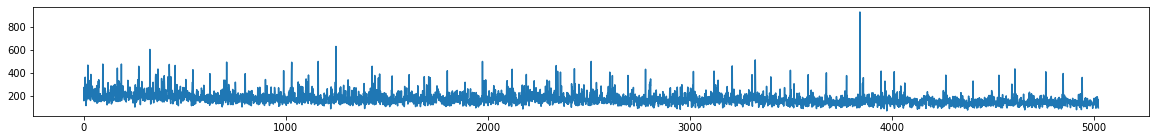

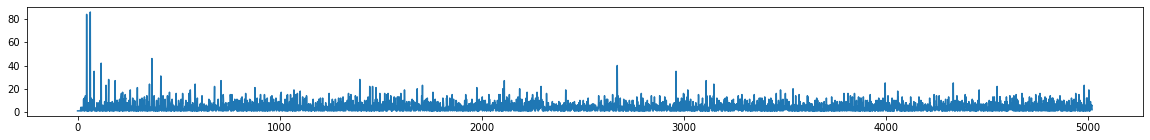

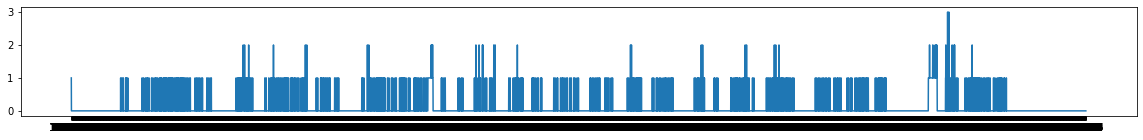

In [11]:
#Covert h:m:s format into a numeric value for timeseries
check2 = bot_count_2.groupby('Flow_Start').size()
h=17 # to 19
m=16 # to 17
s=49
zeroes = pd.DataFrame([['17:16:47', 0]])
while (h < 19) or (m < 18):
    s += 1
    if s > 59:
        m += 1
        s = 0
    if m > 59:
        m = 0
        h += 1
    if sum(check2.index== str(h)+":"+str(m)+":"+str(s))  < 1:
        zero = pd.DataFrame([[str(h)+":"+str(m)+":"+str(s), 0]])
        zero.columns=["Flow_Start", 'Count']
        bot_count_2 = pd.concat([bot_count_2, zero])
combined.set_index('Flow_Start')
import matplotlib.pyplot as plt
fig = plt.figure(num=None, figsize=(20, 2))

plt.plot(combined.index, combined.All_Packets)
fig = plt.figure(num=None, figsize=(20, 2))
plt.plot(combined.index, combined.Botnet_Packets)
fig = plt.figure(num=None, figsize=(20, 2))
bot_count_3 = bot_count_2
bot_count_3 = bot_count_3.sort_values('Flow_Start').reset_index()
plt.plot(bot_count_3.Flow_Start, bot_count_3.Count)
# in descending order :All packets, Botnet packets, and Botnet_FILTERLEGITIMATE packets

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  from ipykernel import kernelapp as app


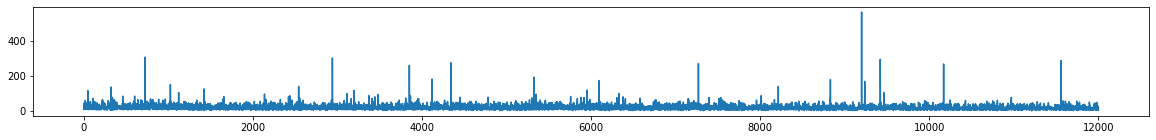

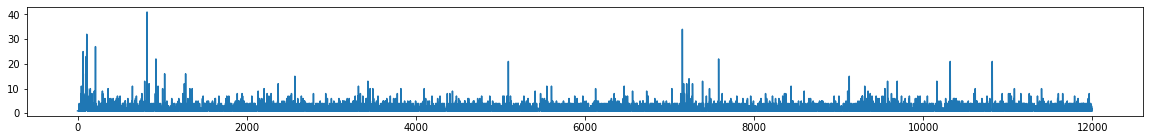

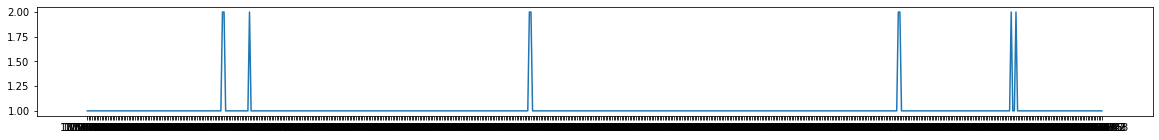

In [12]:
#same graphs, but for a tenth of a second
flow_check = df[['Flow_Start', 'Label']]
for index, row in flow_check.iterrows():
    flow_check.at[index, 'Flow_Start'] = flow_check.at[index, 'Flow_Start'][:10]
bot_traffic_1 = flow_check[flow_check.Label == "Botnetnan"]
bot_traffic_2 = flow_check[flow_check.Label == "BotnetFILTER_LEGITIMATE"]
bot_traffic = pd.concat([bot_traffic_1, bot_traffic_2])
full_count = flow_check.groupby('Flow_Start').size()
bot_count = bot_traffic.groupby('Flow_Start').size()
bot_count = bot_count.reset_index("Flow_Start")
full_count = full_count.reset_index('Flow_Start')
combined = pd.merge(bot_count, full_count, left_on='Flow_Start', right_on='Flow_Start')
combined.columns=['Flow_Start', 'Botnet_Packets', 'All_Packets']
combined.sort_values('Botnet_Packets')
combined.Clean_Packets = combined.All_Packets - combined.Botnet_Packets
bot_count_2 = bot_traffic_2.groupby('Flow_Start').size()
bot_count_2 = bot_count_2.reset_index("Flow_Start")
bot_count_2.columns = ['Flow_Start', 'Count']
fig = plt.figure(num=None, figsize=(20, 2))
plt.plot(combined.index, combined.All_Packets)
fig = plt.figure(num=None, figsize=(20, 2))

plt.plot(combined.index, combined.Botnet_Packets)
fig = plt.figure(num=None, figsize=(20, 2))
bot_count_3 = bot_count_2
bot_count_3 = bot_count_3.sort_values('Flow_Start').reset_index()
plt.plot(bot_count_3.Flow_Start, bot_count_3.Count)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  from ipykernel import kernelapp as app


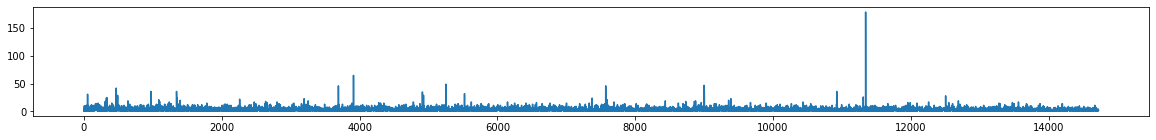

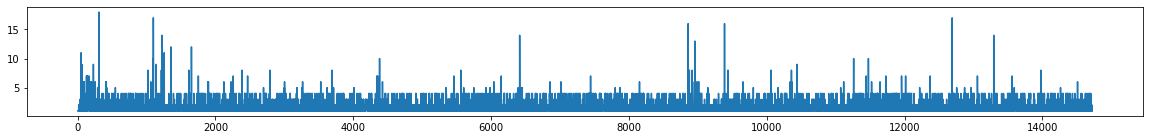

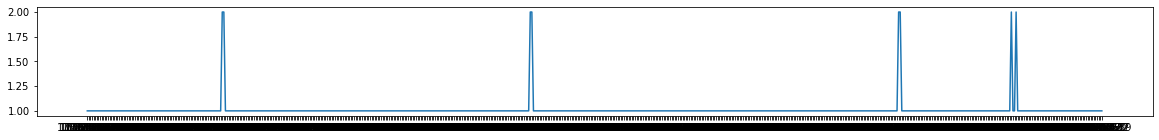

In [13]:
#...and for a hundredth of a second
flow_check = df[['Flow_Start', 'Label']]
for index, row in flow_check.iterrows():
    flow_check.at[index, 'Flow_Start'] = flow_check.at[index, 'Flow_Start'][:11]
bot_traffic_1 = flow_check[flow_check.Label == "Botnetnan"]
bot_traffic_2 = flow_check[flow_check.Label == "BotnetFILTER_LEGITIMATE"]
bot_traffic = pd.concat([bot_traffic_1, bot_traffic_2])
full_count = flow_check.groupby('Flow_Start').size()
bot_count = bot_traffic.groupby('Flow_Start').size()
bot_count = bot_count.reset_index("Flow_Start")
full_count = full_count.reset_index('Flow_Start')
combined = pd.merge(bot_count, full_count, left_on='Flow_Start', right_on='Flow_Start')
combined.columns=['Flow_Start', 'Botnet_Packets', 'All_Packets']
combined.sort_values('Botnet_Packets')
combined.Clean_Packets = combined.All_Packets - combined.Botnet_Packets
bot_count_2 = bot_traffic_2.groupby('Flow_Start').size()
bot_count_2 = bot_count_2.reset_index("Flow_Start")
bot_count_2.columns = ['Flow_Start', 'Count']
fig = plt.figure(num=None, figsize=(20, 2))
plt.plot(combined.index, combined.All_Packets)
fig = plt.figure(num=None, figsize=(20, 2))
plt.plot(combined.index, combined.Botnet_Packets)
fig = plt.figure(num=None, figsize=(20, 2))
bot_count_3 = bot_count_2
bot_count_3 = bot_count_3.sort_values('Flow_Start').reset_index()
plt.plot(bot_count_3.Flow_Start, bot_count_3.Count)

<font size=5><font color='red'>3.	Once the final variable set is created, which of the following techniques most effectively classifies or aides in classifying botnet traffic?<br><br>
<font size=4>h.	Bagging<br><br>
i.	K-Means Clustering<br><br>
j.	Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

## K Means Clustering

In [14]:
df=stage2

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 2).fit(df)
labels=kmeans.fit_predict(df)
kmeans =pd.DataFrame(kmeans.labels_)

kmeans.columns = ["KMeans"]
kmeans = kmeans['KMeans']
df2=df.reset_index().drop('index', axis=1)
for index, row in df2.iterrows():
    df2.at[index, 'KMeans'] = kmeans[index]
key = df2[['Label', 'KMeans']]
cm = pd.DataFrame({'labels':labels, 'class':df2['Label']})
pd.crosstab(cm['labels'], cm['class'])
#50.00%

class,0.0,1.0
labels,,
0,21759,21760
1,1,0


## DBSCAN

In [15]:
from sklearn.cluster import DBSCAN 
#clustering = DBSCAN(eps=3, min_samples=2).fit(df)
dbs = DBSCAN(eps=2, min_samples=3500).fit(df)
DB =pd.DataFrame(dbs.labels_)
DB.columns = ["DBSCAN"]
DB = DB['DBSCAN']
df2=df.reset_index().drop('index', axis=1)
for index, row in df2.iterrows():
    df2.at[index, 'DBSCAN'] = DB[index]
key = df2[['Label', 'DBSCAN']]
print(df2.groupby(["DBSCAN", "Label"]).size())
#55.79%

DBSCAN  Label
-1.0    0.0      21096
        1.0      18575
 0.0    0.0        664
        1.0       3185
dtype: int64


## Bagging Classifier

In [16]:
X = df.drop(['Label'], axis=1)
#X = df.drop(['Label'], axis=1)
y = df.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,random_state=42)
from sklearn.preprocessing import MinMaxScaler
scaler_minmax = MinMaxScaler()
scaler_minmax.fit(X_train)
scaler_minmax.fit(X_test)

from sklearn.metrics import confusion_matrix
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(n_estimators=10).fit(X_train, y_train)
y_pred=clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(clf.score(X_test, y_test))


[[6532    2]
 [   7 6515]]
0.9993106617647058


# With City and Country Removed

## K Means Clustering

In [17]:
df=stage3

kmeans = KMeans(n_clusters = 2).fit(df)
labels=kmeans.fit_predict(df)
kmeans =pd.DataFrame(kmeans.labels_)

kmeans.columns = ["KMeans"]
kmeans = kmeans['KMeans']
df2=df.reset_index().drop('index', axis=1)
for index, row in df2.iterrows():
    df2.at[index, 'KMeans'] = kmeans[index]
key = df2[['Label', 'KMeans']]
cm = pd.DataFrame({'labels':labels, 'class':df2['Label']})
pd.crosstab(cm['labels'], cm['class'])
#50.00%

class,0.0,1.0
labels,,
0,21759,21760
1,1,0


## DBSCAN

In [18]:
dbs = DBSCAN(eps=2, min_samples=3500).fit(df)
DB =pd.DataFrame(dbs.labels_)
DB.columns = ["DBSCAN"]
DB = DB['DBSCAN']
df2=df.reset_index().drop('index', axis=1)
for index, row in df2.iterrows():
    df2.at[index, 'DBSCAN'] = DB[index]
key = df2[['Label', 'DBSCAN']]
print(df2.groupby(["DBSCAN", "Label"]).size())
#55.97%

DBSCAN  Label
-1.0    0.0      21065
        1.0      18467
 0.0    0.0        695
        1.0       3293
dtype: int64


## Bagging Classifier

In [24]:
#note that the confusion matrix here is with test size 3. The one in the slideshow from earlier with test size 2

X = df.drop(['Label'], axis=1)

y = df.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,random_state=42)
scaler_minmax = MinMaxScaler()
scaler_minmax.fit(X_train)
scaler_minmax.fit(X_test)

from sklearn.metrics import confusion_matrix
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(n_estimators=10).fit(X_train, y_train) #this will produce slightly different results every time
y_pred=clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(clf.score(X_test, y_test))

[[5912  622]
 [ 406 6116]]
0.9212622549019608
